# Shockwave

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Parameters
L = 1.0         # Length of the domain
T = 1.0         # Total simulation time
Nx = 200        # Number of spatial points
Nt = 800        # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt

In [116]:
# Initial conditions
x = np.linspace(0, L, Nx)
gamma = 1.4
u = 0.75*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
u[60:] = 0
rho = np.ones(Nx)
rho[60:] = 0.125
press = np.ones(Nx)
press[60:] = 0.1

energy = np.zeros(Nx)
energy = press/((gamma - 1)) + 0.5*rho*u**2

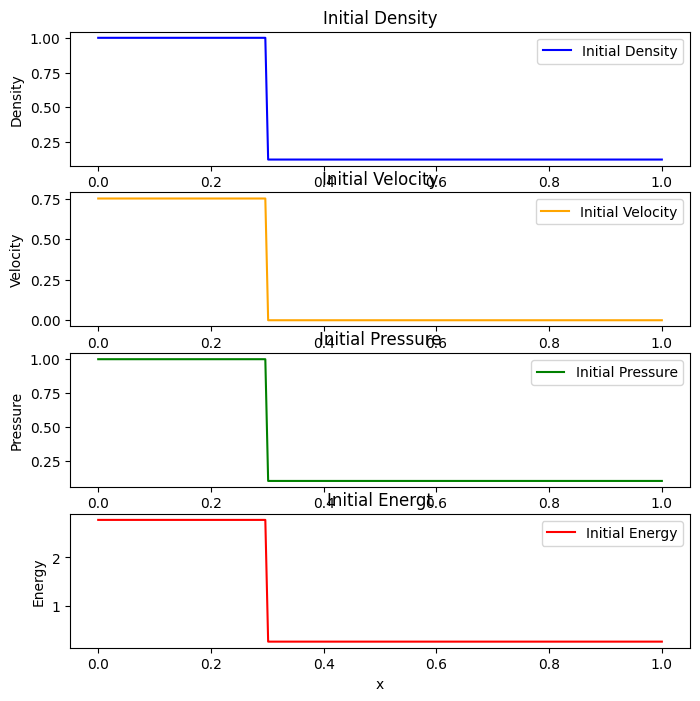

In [117]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8))
axs[0].plot(x, rho, label='Initial Density', color='blue')
axs[0].set_title('Initial Density')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Density')
axs[0].legend()

axs[1].plot(x, u, label='Initial Velocity', color='orange')
axs[1].set_title('Initial Velocity')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Velocity')
axs[1].legend()

axs[2].plot(x, press, label='Initial Pressure', color='green')
axs[2].set_title('Initial Pressure')
axs[2].set_xlabel('x')
axs[2].set_ylabel('Pressure')
axs[2].legend()

axs[3].plot(x, energy, label='Initial Energy', color='red')
axs[3].set_title('Initial Energt')
axs[3].set_xlabel('x')
axs[3].set_ylabel('Energy')
axs[3].legend()

In [118]:
sol_rho = np.zeros((rho.shape[0], Nt+1))
sol_mom = np.zeros((rho.shape[0], Nt+1))
sol_ene = np.zeros((rho.shape[0], Nt+1))
sol_pre = np.zeros((rho.shape[0], Nt+1))


sol_rho[:, 0] = rho
sol_mom[:, 0] = rho * u
sol_ene[:, 0] = energy

In [128]:
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)
v = np.zeros(Nx)
v_prov = np.zeros(Nx-1)
v[sol_rho[:,0]!=0] = sol_mom[:, 0][sol_rho[:,0]!=0]/sol_rho[:,0][sol_rho[:,0]!=0]

for i in range(1, Nt+1):
    press = sol_pre[:,i-1]
    f_rho = sol_mom[:,i-1]
    f_mom = press + sol_rho[:,i-1]*v**2
    f_ene = v * (sol_ene[:,i-1] + press)
    
    u_prov = 0.5*(sol_mom[1:,i-1] + sol_mom[:-1,i-1]) - 0.5*dt*(f_mom[1:] - f_mom[:-1])/dx
    r_prov = 0.5*(sol_rho[1:,i-1] + sol_rho[:-1,i-1]) - 0.5*dt*(f_rho[1:] - f_rho[:-1])/dx
    e_prov = 0.5*(sol_ene[1:,i-1] + sol_ene[:-1,i-1]) - 0.5*dt*(f_ene[1:] - f_ene[:-1])/dx

    v_prov[r_prov!=0] = u_prov[r_prov!=0]/r_prov[r_prov!=0]
    press_prov = (gamma - 1) * (e_prov - 0.5*r_prov * v_prov**2) 
    f_rho_prov = u_prov
    f_mom_prov = press_prov + r_prov*v_prov**2
    f_ene_prov = v_prov*(e_prov + press_prov)

    diff_rho[1:-1] = f_rho_prov[1:] - f_rho_prov[:-1]
    diff_mom[1:-1] = f_mom_prov[1:] - f_mom_prov[:-1]
    diff_ene[1:-1] = f_ene_prov[1:] - f_ene_prov[:-1]

    sol_mom[:,i] = sol_mom[:,i-1] - dt*(diff_mom)/dx
    sol_rho[:,i] = sol_rho[:,i-1] - dt*(diff_rho)/dx
    sol_ene[:,i] = sol_ene[:,i-1] - dt*(diff_ene)/dx
    
    v[sol_rho[:,i]!=0] = sol_mom[:, i][sol_rho[:,i]!=0]/sol_rho[:,i][sol_rho[:,i]!=0]
    sol_pre[:,i] = (gamma - 1) *(sol_ene[:,i] - 0.5* sol_rho[:,i]* v**2)

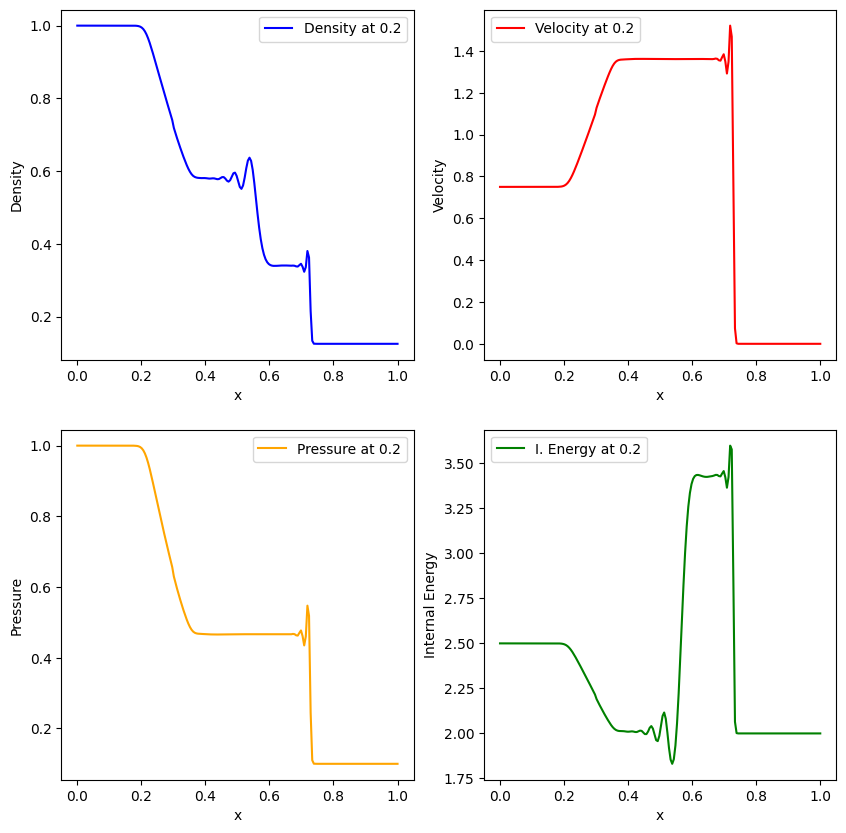

In [143]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, sol_rho[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, sol_pre[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, sol_mom[:,idx]/sol_rho[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, (sol_ene[:,idx]/sol_rho[:,idx] - 0.5*(sol_mom[:,idx]/sol_rho[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

### ROE 